## Final Project: Phase 3 - Avoiding False Discoveries
Spring 2024  
Group: Michael Massone and Joseph Nelson Farrell   
DS 5230 Unsupervised Machine Learning  
Professor Steven Morin, PhD  
Due: 04/17/2024  
___

### Import Libraries

In [1]:
# base
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


# pathing
from pathlib import Path
import os
import sys

import umap

import time


___

### Start Timer

In [2]:
# track runtime
start = time.time()

### Set Paths

In [3]:
# define path
HOME = Path(os.getcwd())
print(HOME)

HOME_PARENT_STR = str(HOME.parent)
print(HOME_PARENT_STR)

# path to figs folder
PATH_TO_FIGS_FOLDER = HOME_PARENT_STR + '/figs'

# path to data
PATH_TO_DATA_FOLDER = HOME_PARENT_STR + '/data'

# path to src folder
PATH_TO_SRC = HOME_PARENT_STR + '/src'
print(PATH_TO_SRC)

# sys path
sys.path.append(PATH_TO_SRC)

/Users/mikey/LocalFiles/DS5230/final_project/DS5230-final/notebooks
/Users/mikey/LocalFiles/DS5230/final_project/DS5230-final
/Users/mikey/LocalFiles/DS5230/final_project/DS5230-final/src


### Import Functions

In [4]:
import afd_utils
import cluster_utils

### Import Data

In [5]:
results_frame_file =  '/results/filtered_results_2024-04-1813:01:34.137038.csv'
results_frame = pd.read_csv(PATH_TO_DATA_FOLDER + results_frame_file)

### Check for Kmeans

In [6]:
# check if there is a Kmeans solution
if 'k_means' in list(results_frame['algo']):
    print("There is a Kmeans Solution. Proceed")
else:
    print('There is not Kmeans solution to check. Exit notebook.')

There is a Kmeans Solution. Proceed


### Filter for Kmeans

In [7]:
# filter results for k_means solution
results_frame = results_frame[results_frame["algo"] == "k_means"]
results_frame

,algo,n_clusters_found,n_clusters_db_score_is_min,n_clusters_ch_score_is_max,n_clusters_silhouette_score_is_max,silhouette_score,hopkins_statistic,umap_n_neighbors,umap_min_dist,umap_metric,umap_n_components,trustworthiness,eps,dbscan_min_samples,dbscan_metric,validity_index,noise_ratio,cluster_labels
1,k_means,15,15.0,15.0,15.0,0.519526,0.002861,750,0.0,euclidean,7,0.999954,NaN,NaN,NaN,NaN,NaN,"5,14,7,7,9,5,4,5,12,13,1,6,11,0,13,12,1,2,14,6..."


### Get Best Kmeans

In [8]:
results_frame.sort_values('silhouette_score', ascending = False, inplace = True)
results_frame.reset_index(drop = True, inplace = True)
best_result = pd.DataFrame(results_frame.loc[0, :]).T
best_result

,algo,n_clusters_found,n_clusters_db_score_is_min,n_clusters_ch_score_is_max,n_clusters_silhouette_score_is_max,silhouette_score,hopkins_statistic,umap_n_neighbors,umap_min_dist,umap_metric,umap_n_components,trustworthiness,eps,dbscan_min_samples,dbscan_metric,validity_index,noise_ratio,cluster_labels
0,k_means,15,15.0,15.0,15.0,0.519526,0.002861,750,0.0,euclidean,7,0.999954,NaN,NaN,NaN,NaN,NaN,"5,14,7,7,9,5,4,5,12,13,1,6,11,0,13,12,1,2,14,6..."


### Get Cap X

In [9]:
# get the design matrix
design_file = '/curated/shuffled_design.csv'
design_matrix_shuffled = pd.read_csv(PATH_TO_DATA_FOLDER + design_file)

# drop ID col
design_matrix_shuffled_noID = design_matrix_shuffled.drop('ID', axis=1)

# convert to ndarray
cap_x = design_matrix_shuffled_noID.to_numpy()
cap_x = design_matrix_shuffled
cap_x.shape

# get umap hypers from results frame
n_neighbors = results_frame['umap_n_neighbors'][0]
n_components = results_frame['umap_n_components'][0]
metric = results_frame['umap_metric'][0]
min_dist = results_frame['umap_min_dist'][0]

# get the latent embedding discovered in the gridsearch
reducer = umap.UMAP(
        n_neighbors = n_neighbors, 
        n_components = n_components, 
        metric = metric, 
        min_dist = min_dist, 
        spread = 1.0, 
        random_state = 42
        )

# fit and embed
reducer.fit(cap_x)
embedding = reducer.transform(cap_x)

/Users/mikey/miniconda3/envs/usml_base_ds2/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [10]:
# create results list
results_list = []
n_clusters = results_frame['n_clusters_found'][0]

# get sil score of cap_x
silhouette_score_cap_x = afd_utils.cluster_kmeans(embedding, n_clusters)
results_list.append({'data': 'cap_x', 'silhouette_score': silhouette_score_cap_x})

# generate and cluster random data
for i in range(40):
    random_data = afd_utils.get_randomly_distributed_data(embedding, seed = i)
    silhouette_score_random = afd_utils.cluster_kmeans(random_data, n_clusters)
    results_list.append({'data': 'random', 'silhouette_score': silhouette_score_random})

# convert to results frame
results_df = pd.DataFrame(results_list)
print(results_df)

/Users/mikey/miniconda3/envs/usml_base_ds2/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/mikey/miniconda3/envs/usml_base_ds2/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/mikey/miniconda3/envs/usml_base_ds2/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/mikey/miniconda3/envs/usml_base_ds2/lib/python3.10/site-packages/sklearn/cluster/

      data  silhouette_score
0    cap_x          0.519437
1   random          0.115390
2   random          0.116928
3   random          0.115378
4   random          0.115029
5   random          0.115189
6   random          0.114670
7   random          0.114130
8   random          0.115740
9   random          0.115210
10  random          0.113970
11  random          0.115522
12  random          0.114791
13  random          0.115305
14  random          0.115695
15  random          0.114686
16  random          0.114310
17  random          0.114742
18  random          0.115553
19  random          0.113913
20  random          0.115188
21  random          0.115012
22  random          0.115063
23  random          0.114626
24  random          0.113124
25  random          0.114069
26  random          0.115853
27  random          0.114138
28  random          0.114928
29  random          0.116331
30  random          0.114322
31  random          0.113506
32  random          0.113853
33  random    

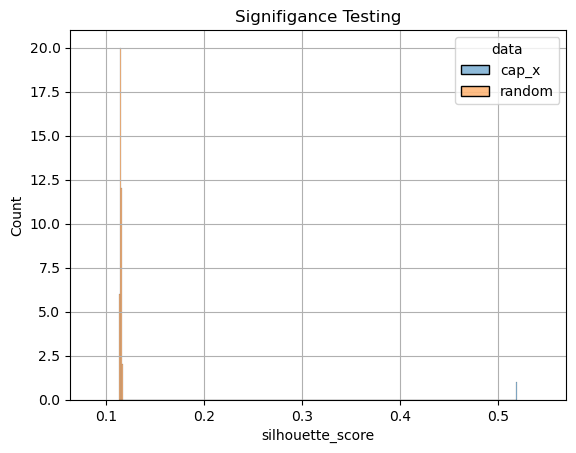

In [17]:
sns.histplot(data=results_df, x = 'silhouette_score', hue = 'data', binwidth=0.001)
sil_max = results_df['silhouette_score'].max()
sil_min = results_df['silhouette_score'].min()
plt.xlim([sil_min - .05, sil_max + 0.05])
plt.grid()
plt.title('Signifigance Testing')
plt.savefig(PATH_TO_FIGS_FOLDER + 'sig_test.png', bbox_inches='tight')
plt.show()

___

## Runtime

In [12]:
finish = time.time()
hours = int((finish - start) // 3600)
minutes = int(((finish - start) % 3600) // 60)
seconds = int((finish - start) % 60)
print(f"Total Run Time(hh:mm.ss): {hours:02d}:{minutes:02d}.{seconds:02d}")

Total Run Time(hh:mm.ss): 00:03.50
